In [ ]:
# 먼저 완전한 방전 전압 곡선을 사용해서 모델을 학습

In [18]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR

In [19]:
# figure를 위한 라이브러리
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation
mpl.rcParams['font.size'] = 30

In [20]:
path = os.getcwd()
print(path)

/content


In [21]:
def all_load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10] # discharge
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        # df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        # df = df[df["Voltage"] >2.95] # 원래는 2.95
        df["Charge_Capacity"] /= 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [22]:
def load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10]
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        # df = df[df["Voltage"] >2.9] # 학습시킬 voltage segment구간>> 이걸 바꿔가면서 모델링 진행하면됨 원래 2.95
        df = df[df["Voltage"] >2]
        # df["Charge_Capacity"] /= 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [23]:
def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try: #동일한 시작점으로 맞춰주는 과정
                time = time - time[0] 
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()

In [24]:
# def plot_cycles(d, cycle):
#     print("plotting...")
#     for i,c in enumerate(cycle):
#       cycle_data = d[d.Cycle_Index == c]
#       time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
#       plt.xlabel("time")
#       plt.ylabel("voltage")
#       plt.plot(time,voltage)

#     plt.show()

In [25]:
def fit_spline(data, cycles, no_points=500): # no_points 구간별 point 개수
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Charge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1) # class 반환

            # creating linear space 0, 200 of 20,000 points >> 0에서 700사이의 20000개의 일정한 간격의 요소를 만듬
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi) # 불연속인 y값을 대체할 yi_test값 생성

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2)) #argmin 최솟값 위치 색인 
            # index_2 = np.argmin(np.abs(yi_test - 3)) # 원래 3
            index_2 = np.argmin(np.abs(yi_test - 2.1)) # 원래 3

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
            # if yi[yi<2.998].any():
            #     continue
# 각 변수별 일차원 배열을 생성해주는 과정                       
            ind = np.zeros_like(xi) + ind.values[0] #ind = step_time
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append(np.array([xi, yi, capacity, ind])) # 리스트에 합침
        cell_np = np.concatenate(cell_np, axis=1) 
        cell_np = np.transpose(cell_np, (1,0)) 
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'Charge_Capacity', 'Cycle_Index']) # 데이터 프레임화
        i+=1
        
    return data

In [26]:
def find_error(data, cycles): # fit_spline 함수 에러 뜬 데이터 오류난 부분의 인덱스를 잡는 함수
    
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            
            pts = len(time)
            
            for i in range(pts -1):
                if time[i + 1] - time[i] <= 0:
                    print (f"Error is in {c} cycle at time {time[i]}")

In [27]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 모델링 시간 그래프

In [ ]:
time_df=pd.DataFrame({'id':['b1c2','b1c31','b1c42','b2c1','b1c1','b3c16'],'cycle':[2235,874,700,170,2158,1637],'time':[15.3689,3.2264,2.3866,0.4301,14.3965,7.8849],'outlier':[1,0,0,0,1,1]})
time_df

,id,cycle,time,outlier
0,b1c2,2235,15.3689,1
1,b1c31,874,3.2264,0
2,b1c42,700,2.3866,0
3,b2c1,170,0.4301,0
4,b1c1,2158,14.3965,1
5,b3c16,1637,7.8849,1


<ipython-input-12-2f48730bd145>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(time_df['cycle'],time_df['time'],cmap='Greens',edgecolors='black',linewidth=2,s=200)


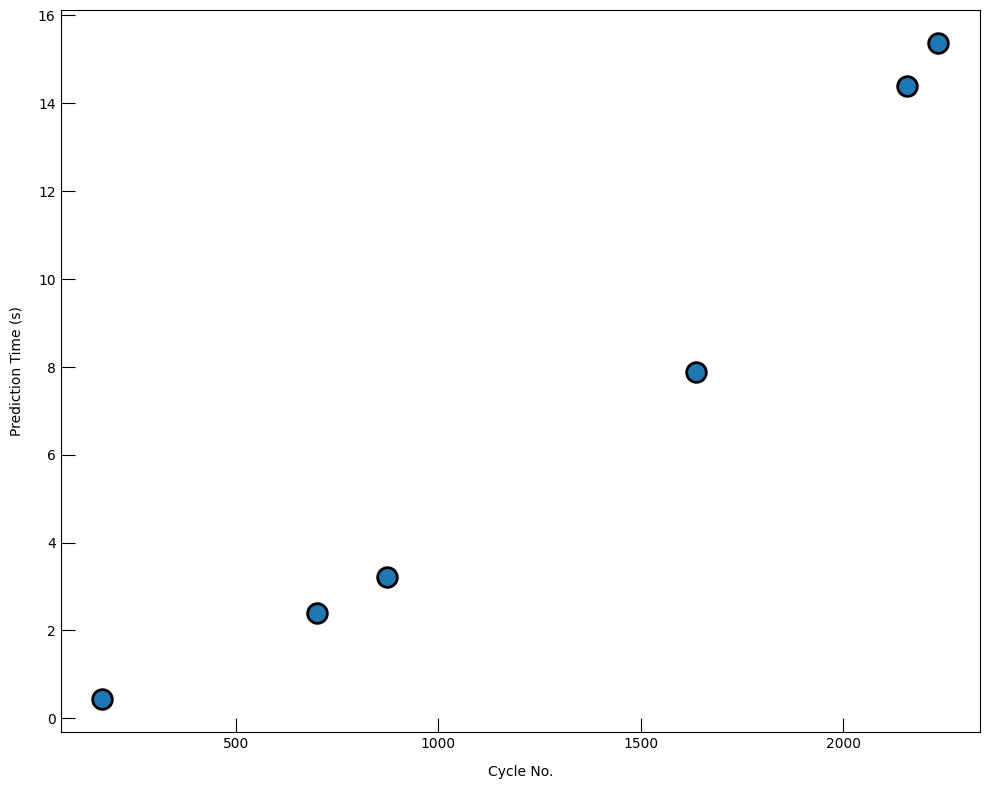

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(time_df['cycle'],time_df['time'],cmap='Greens',edgecolors='black',linewidth=2,s=200)
plt.tick_params(direction='in',length=10)
plt.ylabel('Prediction Time (s)',labelpad=10)
plt.xlabel('Cycle No.',labelpad=10)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/predict_time2.png',dpi=600)

# 전처리

In [15]:
# mit_csv have pathes of all csv files in raw_mit file(즉 방전상태 뿐만아니라 충전과정 까지 포함한 데이터) > 총 10개의 모집단
# mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//*csv") # 방전 그래프 
mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl//*csv") # 전체 충방전 그래프 그릴때

#glob("./Capacity_data/MIT/*")
for csv in mit_csvs:
    print (csv)
# b1이 들어간 파일은 mit_csv리스트에 담지 않는다
mit_csvs = [i for i in mit_csvs if "b1c21" not in i]


/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/b1c2.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/b1c1.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_8C-25per_3_6C_CH45_b1c42.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_5_4C-60per_3C_CH16_b1c15.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_5_4C-80per_5_4C_CH12_b1c20.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_5_4C-80per_5_4C_CH11_b1c21.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_6C-40per_3C_CH25_b1c24.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_6C-40per_3C_CH26_b1c25.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_6C-40per_3_6C_CH34_b1c27.csv
/content/drive/MyDrive//battery capcity estimation//data//CSV f

In [16]:
# reducted entire voltage curve
mit_data, mit_cycles = load_csvs(mit_csvs)
# plot_cycles(mit_data, mit_cycles)

2236
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/b1c2.csv (975629, 7)
2159
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/b1c1.csv (937099, 7)
701
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_8C-25per_3_6C_CH45_b1c42.csv (299059, 7)
718
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_5_4C-60per_3C_CH16_b1c15.csv (309238, 7)
533
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_5_4C-80per_5_4C_CH12_b1c20.csv (222181, 7)
1016
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_6C-40per_3C_CH25_b1c24.csv (432042, 7)
853
total points in /content/drive/MyDrive//battery capcity estimation//data//CSV from pkl/2017-05-12_6C-40per_3C_CH26_b1c25.csv (364532, 7)
841
total points in /content/drive/MyDrive//battery capcity 

In [13]:
temp = mit_data[0].loc[:,['Cycle_Index','Step_Time','Voltage']]
temp['Capacity'] = mit_data[0].loc[:,'Charge_Capacity']
temp

,Cycle_Index,Step_Time,Voltage,Capacity
3,1,0.1484,2.039835,0.000001
4,1,0.1742,2.052117,0.000001
5,1,0.1912,2.063246,0.000001
6,1,0.2168,2.081058,0.000001
7,1,0.2424,2.101640,0.000001
...,...,...,...,...
2370987,2235,2522.0313,2.000050,0.881266
2370988,2235,2525.8997,2.000437,0.881266
2370989,2235,2525.9620,2.001718,0.881266
2370990,2235,2526.6196,2.011725,0.881266


# 모델의 전처리 과정을 보여주는 피규어

In [ ]:
len(mit_data)

10

In [ ]:
k = mit_data[2]
k = k.loc[(k['Cycle_Index']>=80)&(k['Cycle_Index']<=100)]
k.head()

,Cycle_Index,Step_Index,Step_Time,Current,Voltage,Charge_Capacity,Discharge_Capacity
86736,80,10,0.1466,0.350925,2.031791,0.000002,2.193239e-09
86737,80,10,0.1467,0.350925,2.031791,0.000002,2.193239e-09
86738,80,10,0.1678,0.612946,2.047570,0.000002,2.193239e-09
86739,80,10,0.1777,0.789104,2.060512,0.000002,2.193239e-09
86740,80,10,0.1978,1.053402,2.083689,0.000002,2.193239e-09


In [ ]:
# time1 = k[k['Cycle_Index']==1].iloc[-1,2]
# k.loc[k.Cycle_Index==2,'Step_Time']+=time1
# time2 = k[k['Cycle_Index']==2].iloc[-1,2]
# k.loc[k.Cycle_Index==3,'Step_Time']+=time2
# time3 = k[k['Cycle_Index']==3].iloc[-1,2]
# k.loc[k.Cycle_Index==4,'Step_Time']+=time3
# time4 = k[k['Cycle_Index']==4].iloc[-1,2]
# k.loc[k.Cycle_Index==5,'Step_Time']+=time4
# time5 = k[k['Cycle_Index']==5].iloc[-1,2]
# k.loc[k.Cycle_Index==6,'Step_Time']+=time5
# time6 = k[k['Cycle_Index']==6].iloc[-1,2]
# k.loc[k.Cycle_Index==7,'Step_Time']+=time6
# time7 = k[k['Cycle_Index']==7].iloc[-1,2]
# k.loc[k.Cycle_Index==8,'Step_Time']+=time7
# time8 = k[k['Cycle_Index']==8].iloc[-1,2]
# k.loc[k.Cycle_Index==9,'Step_Time']+=time8
# time9 = k[k['Cycle_Index']==9].iloc[-1,2]
# k.loc[k.Cycle_Index==10,'Step_Time']+=time9
# time10 = k[k['Cycle_Index']==10].iloc[-1,2]
# k.loc[k.Cycle_Index==11,'Step_Time']+=time10

In [ ]:
for i in range(80,100):
  time = k[k['Cycle_Index']==i].iloc[-1,2]
  k.loc[k.Cycle_Index==i+1,'Step_Time']+=time

In [ ]:
k1 = k.loc[k['Current']==0]
k1

,Cycle_Index,Step_Index,Step_Time,Current,Voltage,Charge_Capacity,Discharge_Capacity
87847,80,10,3125.2380,0.0,2.016312,1.083789,1.083785
88957,81,10,6250.4423,0.0,2.016123,1.083779,1.083765
90049,82,10,9375.7080,0.0,2.016444,1.083818,1.083789
91146,83,10,12500.9402,0.0,2.016032,1.083745,1.083718
92243,84,10,15626.1388,0.0,2.015916,1.083745,1.083725
93352,85,10,18751.3611,0.0,2.016025,1.083723,1.083643
94461,86,10,21876.5798,0.0,2.016239,1.083610,1.083578
95564,87,10,25001.8046,0.0,2.015960,1.083584,1.083600
96646,88,10,28127.0253,0.0,2.015789,1.083587,1.083542
97749,89,10,31252.2245,0.0,2.015979,1.083549,1.083536


In [ ]:
data_voltage = pd.to_numeric(k['Voltage'])
data_voltage.reset_index(inplace=True, drop=True)
data_cycle = pd.to_numeric(k['Cycle_Index'])
data_cycle.reset_index(inplace=True, drop=True)
data_Capacity = pd.to_numeric(k['Charge_Capacity'])
data_Capacity.reset_index(inplace=True, drop=True)

In [ ]:
# fig = plt.figure(figsize=(9,6))

# def animate(i):
#   x = np.linspace(0,i,i+1)
#   y1 = data_voltage[:i+1]
#   plt.cla()
#   plt.plot(x,y1,label='Volatage',lw=3)
#   plt.ylabel('Voltage')
#   plt.xlabel('Time')
#   plt.legend()
#   plt.tight_layout()

# ani = FuncAnimation(plt.gcf(),animate,frames=4000,interval=1)
# ani.save('/content/drive/MyDrive//battery capcity estimation/new figure/animation.gif',fps=200)

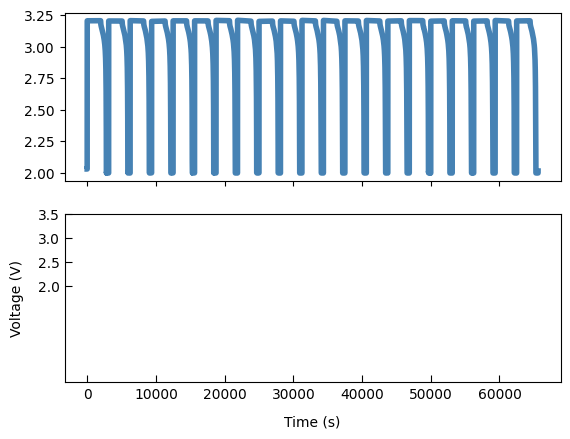

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

# ax1.plot('Step_Time','Voltage',data=k,color='steelblue',linewidth=4)
# # seg = (k.Voltage < 3.2)&(k.Voltage > 2.2)&(k.Current<0)
# # plt.scatter(k.Step_Time[seg],k.Voltage[seg],color='red',s=100)

# plt.ylabel('Voltage (V)',labelpad=10)
# plt.xlabel('Time (s)',labelpad=10)
# plt.tick_params(direction='in',length=5)
# # plt.xticks([0,4000,8000,12000])
# plt.yticks([2,2.5,3,3.5])
# plt.show()
# # v1 = mlines.Line2D([], [], color='red',label='discharge curve',linewidth=7)
# # plt.legend(handles=[v1],frameon=False)
# # plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/all charge&discharge graph.png',dpi=600)

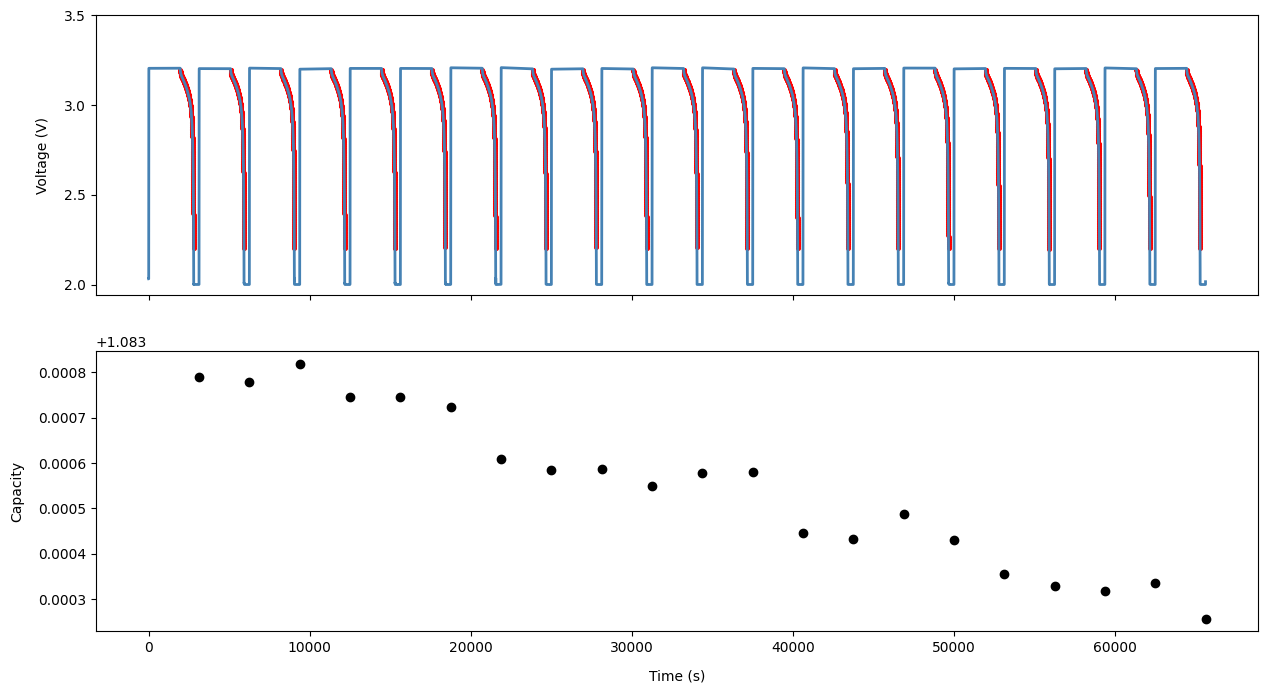

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(15,8))
ax1.plot('Step_Time','Voltage',data=k,color='steelblue',linewidth=2)
seg = (k.Voltage < 3.2)&(k.Voltage > 2.2)&(k.Current<0)
ax1.scatter(k.Step_Time[seg],k.Voltage[seg],color='red',s=7)
ax1.set_ylabel('Voltage (V)',labelpad=10)
ax2.set_xlabel('Time (s)',labelpad=10)
ax1.set_yticks([2,2.5,3,3.5])

ax2.scatter('Step_Time','Charge_Capacity',data=k1,color='black')
ax2.set_ylabel('Capacity',labelpad=10)
plt.show()

In [ ]:
mit_data[5]

,Unnamed: 0,Cycle_Index,Step_Index,Step_Time,Current,Voltage,Charge_Capacity,Discharge_Capacity
41,673,1,10,1893.0699,-4.400073,3.209432,1.094660,0.037922
42,674,1,10,1898.0700,-4.400099,3.201415,1.094660,0.044034
43,675,1,10,1903.0739,-4.400063,3.195294,1.094660,0.050152
44,676,1,10,1908.0794,-4.399835,3.190667,1.094660,0.056270
45,677,1,10,1908.0795,-4.399835,3.190667,1.094660,0.056270
...,...,...,...,...,...,...,...,...
379947,913967,874,10,2226.1936,-4.399774,2.195367,0.882192,0.779705
379948,913968,874,10,2226.5001,-4.400321,2.185177,0.882192,0.780871
379949,913969,874,10,2226.7865,-4.400120,2.175134,0.882192,0.780871
379950,913970,874,10,2227.0661,-4.400096,2.165017,0.882192,0.780871


# Test csvs로 test_data만들어주는 과정

170
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (67568, 8)
plotting...


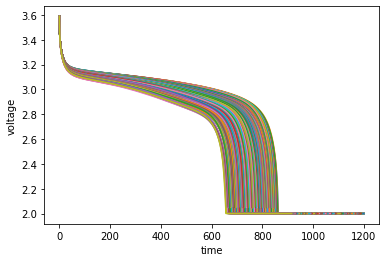

In [ ]:
# original discharge voltage curve(data before reduction)
test_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv")
test_csvs, test_cycles = all_load_csvs(test_csvs)
plot_cycles(test_csvs, test_cycles)

plotting...


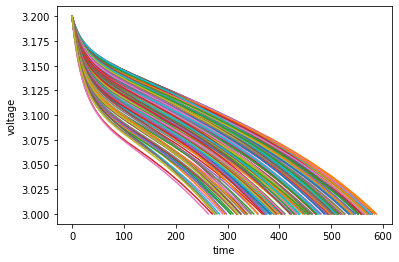

In [ ]:
test_data = fit_spline(test_csvs.copy(), test_cycles, no_points=500)
plot_cycles(test_data, test_cycles)

170
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (44343, 8)
plotting...


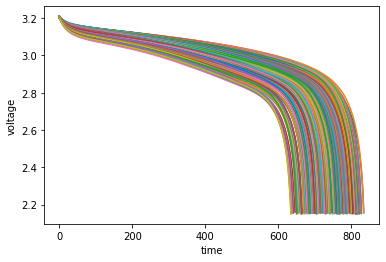

In [ ]:
# reducted discharge voltage curve(data after reduction)
test_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv")
test_csvs, test_cycles = load_csvs(test_csvs)
plot_cycles(test_csvs, test_cycles)

# Fig 3

In [ ]:
fig3 = test_csvs[0]
fig3=fig3.loc[:,['Cycle_Index','Step_Time','Voltage']]

In [ ]:
fig3cycle = test_cycles[0]
fig3 = fig3.reset_index(drop=True)
fig3

,Cycle_Index,Step_Time,Voltage
0,1,2138.5624,3.206023
1,1,2138.5625,3.206023
2,1,2142.6800,3.195989
3,1,2147.6834,3.187151
4,1,2147.6835,3.187151
...,...,...,...
44338,169,2273.6621,2.191673
44339,169,2273.9384,2.181396
44340,169,2274.2135,2.171026
44341,169,2274.4787,2.160968


In [ ]:
# 무시
pd.set_option('mode.chained_assignment',None)

In [ ]:
df = pd.DataFrame()
for cycle in fig3cycle:
    temp = fig3[fig3.Cycle_Index == cycle]
    temp = temp.reset_index(drop=True)
    first = temp['Step_Time'][0]
    temp['Step_Time']=temp['Step_Time'].apply(lambda x: x-first)
    print(str(cycle)+"번째 완료")
    df = pd.concat([df,temp],axis=1)

1번째 완료
2번째 완료
3번째 완료
4번째 완료
5번째 완료
6번째 완료
7번째 완료
8번째 완료
9번째 완료
10번째 완료
11번째 완료
12번째 완료
13번째 완료
14번째 완료
15번째 완료
16번째 완료
17번째 완료
18번째 완료
19번째 완료
20번째 완료
21번째 완료
22번째 완료
23번째 완료
24번째 완료
25번째 완료
26번째 완료
27번째 완료
28번째 완료
29번째 완료
30번째 완료
31번째 완료
32번째 완료
33번째 완료
34번째 완료
35번째 완료
36번째 완료
37번째 완료
38번째 완료
39번째 완료
40번째 완료
41번째 완료
42번째 완료
43번째 완료
44번째 완료
45번째 완료
46번째 완료
47번째 완료
48번째 완료
49번째 완료
50번째 완료
51번째 완료
52번째 완료
53번째 완료
54번째 완료
55번째 완료
56번째 완료
57번째 완료
58번째 완료
59번째 완료
60번째 완료
61번째 완료
62번째 완료
63번째 완료
64번째 완료
65번째 완료
66번째 완료
67번째 완료
68번째 완료
69번째 완료
70번째 완료
71번째 완료
72번째 완료
73번째 완료
74번째 완료
75번째 완료
76번째 완료
77번째 완료
78번째 완료
79번째 완료
80번째 완료
81번째 완료
82번째 완료
83번째 완료
84번째 완료
85번째 완료
86번째 완료
87번째 완료
88번째 완료
89번째 완료
90번째 완료
91번째 완료
92번째 완료
93번째 완료
94번째 완료
95번째 완료
96번째 완료
97번째 완료
98번째 완료
99번째 완료
100번째 완료
101번째 완료
102번째 완료
103번째 완료
104번째 완료
105번째 완료
106번째 완료
107번째 완료
108번째 완료
109번째 완료
110번째 완료
111번째 완료
112번째 완료
113번째 완료
114번째 완료
115번째 완료
116번째 완료
117번째 완료
118번째 완료
119번째 완료
120번째 완료
121번째 완료
122번째 완료
123번째 완료
1

In [ ]:
df

NameError: ignored

In [ ]:
# df = df.reset_index(drop=True)
df.to_csv('figure3_a(수정).csv',index=False)

# fig 7

In [14]:
# reducted discharge voltage curve(data after reduction)
test_csvs = [
'/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv',
 '/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv',
'/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv',
'/content/drive/MyDrive//battery capcity estimation//data//b1c1corrected.csv',
'/content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv']


test_csvs

['/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv',
 '/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv',
 '/content/drive/MyDrive//battery capcity estimation//data//b1c1corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv']

In [15]:
test_csvs, test_cycles = load_csvs(test_csvs)
test_data = fit_spline(test_csvs.copy(), test_cycles, no_points=500)
# plot_cycles(test_csvs, test_cycles)

874
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (291392, 8)
700
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv (240259, 12)
170
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (52984, 8)
2158
total points in /content/drive/MyDrive//battery capcity estimation//data//b1c1corrected.csv (722867, 8)
2235
total points in /content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv (753645, 8)


In [ ]:
all_CV = pd.DataFrame()

In [ ]:
import math
div = math.floor(test_csvs[4]['Cycle_Index'].unique().tolist()[-1]/5)
div
a=1
lst = []
for i in range(6):
  print(a)
  lst.append(a)
  a+=div

1
448
895
1342
1789
2236


In [ ]:
test = test_csvs[0] # 바로 뒤뒤에 플랏용
# test = test_data[4] # 뒤뒤뒤 플랏용
test.rename(columns = {'Unnamed: 0' : 'idx'}, inplace = True)

In [ ]:
cycle1  = test[test.Cycle_Index == 1]
start = cycle1['Step_Time'].values[0]
cycle1['Step_Time'] = cycle1['Step_Time']-start

cycle700  = test[test.Cycle_Index == 700]
start = cycle700['Step_Time'].values[0]
cycle700['Step_Time'] = cycle700['Step_Time']-start

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
test_cycles[4][-1]

2235

In [ ]:
for i in range(2235):
  test.loc[test.Cycle_Index==i,'Step_Time']=test.loc[test.Cycle_Index==i,'Step_Time']-test.loc[test.Cycle_Index==i,'Step_Time'][0]

KeyError: ignored

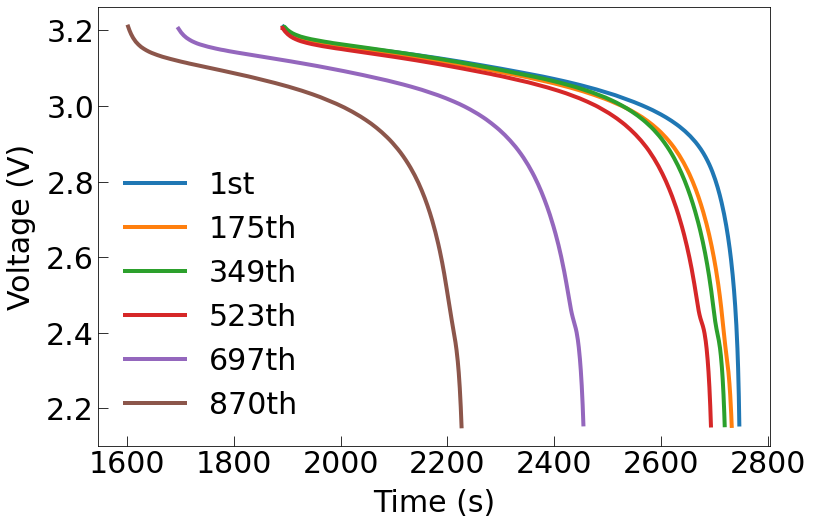

In [ ]:
voltage504 = test.loc[test['Cycle_Index']==lst[0]]['Voltage']
time504 = test.loc[test['Cycle_Index']==lst[0]]['Step_Time']
voltage505 = test.loc[test['Cycle_Index']==lst[1]]['Voltage']
time505 = test.loc[test['Cycle_Index']==lst[1]]['Step_Time']
voltage506 = test.loc[test['Cycle_Index']==lst[2]]['Voltage']
time506 = test.loc[test['Cycle_Index']==lst[2]]['Step_Time']
voltage507 = test.loc[test['Cycle_Index']==lst[3]]['Voltage']
time507 = test.loc[test['Cycle_Index']==lst[3]]['Step_Time']
voltage508 = test.loc[test['Cycle_Index']==lst[4]]['Voltage']
time508 = test.loc[test['Cycle_Index']==lst[4]]['Step_Time']
voltage509 = test.loc[test['Cycle_Index']==lst[5]-1]['Voltage']
time509 = test.loc[test['Cycle_Index']==lst[5]-1]['Step_Time']


ax = plt.figure(figsize=(12,8))
plt.plot(time504,voltage504,linewidth=4,label=str(lst[0])+'st')
plt.plot(time505,voltage505,linewidth=4,label=str(lst[1])+'th')
plt.plot(time506,voltage506,linewidth=4,label=str(lst[2])+'th')
plt.plot(time507,voltage507,linewidth=4,label=str(lst[3])+'th')
plt.plot(time508,voltage508,linewidth=4,label=str(lst[4])+'th')
plt.plot(time509,voltage509,linewidth=4,label=str(lst[5]-1)+'th') 
plt.ylabel('Voltage (V)',labelpad=10)
plt.xlabel('Time (s)',labelpad=10)
# plt.yticks([2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6])
# plt.xticks([0,200,400,600,800,1000])
plt.tick_params(direction='in',length=10)
plt.tight_layout()
plt.legend(frameon=False)
# plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/fig7/fig7_b1c2.png',dpi=600)

In [ ]:
cycle1

,Step_Time,Voltage,Charge_Capacity,Cycle_Index
0,0.000000,3.199996,0.995145,1.0
1,1.365068,3.198326,0.995145,1.0
2,2.765138,3.196614,0.995145,1.0
3,4.165208,3.194997,0.995145,1.0
4,5.530277,3.193735,0.995145,1.0
...,...,...,...,...
495,688.274414,2.986027,0.995145,1.0
496,689.639482,2.985023,0.995145,1.0
497,691.039552,2.984009,0.995145,1.0
498,692.439622,2.982996,0.995145,1.0


In [ ]:
voltage_lst = [2,2.2,2.4,2.6,2.8,3.0,3.2,3.4]

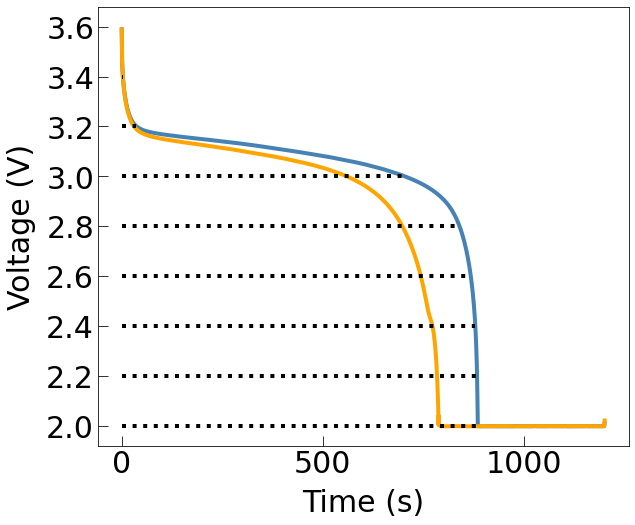

In [ ]:
voltage504 = cycle1['Voltage']
time504 = cycle1['Step_Time']
voltage505 = cycle700['Voltage'] 
time505 = cycle700['Step_Time']
# voltage506 = test.loc[test['Cycle_Index']==lst[2]]['Voltage']
# time506 = test.loc[test['Cycle_Index']==lst[2]]['Step_Time']
# voltage507 = test.loc[test['Cycle_Index']==lst[3]]['Voltage']
# time507 = test.loc[test['Cycle_Index']==lst[3]]['Step_Time']
# voltage508 = test.loc[test['Cycle_Index']==lst[4]]['Voltage']
# time508 = test.loc[test['Cycle_Index']==lst[4]]['Step_Time']
# voltage509 = test.loc[test['Cycle_Index']==lst[5]-1]['Voltage']
# time509 = test.loc[test['Cycle_Index']==lst[5]-1]['Step_Time']
# plt.rc('font', size=12)

ax = plt.figure(figsize=(10,8))
plt.plot(time504,voltage504,linewidth=4,color='steelblue')
plt.plot(time505,voltage505,linewidth=4,color='orange')

plt.plot([0],[3.6],color='black',linewidth=4,linestyle='dotted')
for v in voltage_lst:
  vt = cycle1.loc[cycle1['Voltage']<v].iloc[0,0]-1
  time=cycle1.loc[cycle1['idx']==vt].iloc[0,3]
  plt.plot([0,time],[v,v],color='black',linewidth=4,linestyle='dotted')

plt.ylabel('Voltage (V)',labelpad=10)
plt.xlabel('Time (s)',labelpad=10)
plt.yticks([2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6])
# plt.xticks([0,200,400,600,800,1000,1200])
plt.tick_params(direction='in',length=10)
# plt.legend(frameon=False)
plt.tight_layout() # 피규어 안짤리게 해줌
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/mi score/mi location.png',dpi=600)

In [ ]:
voltage_lst = [2.95,3,3.05,3.1,3.15,3.2]

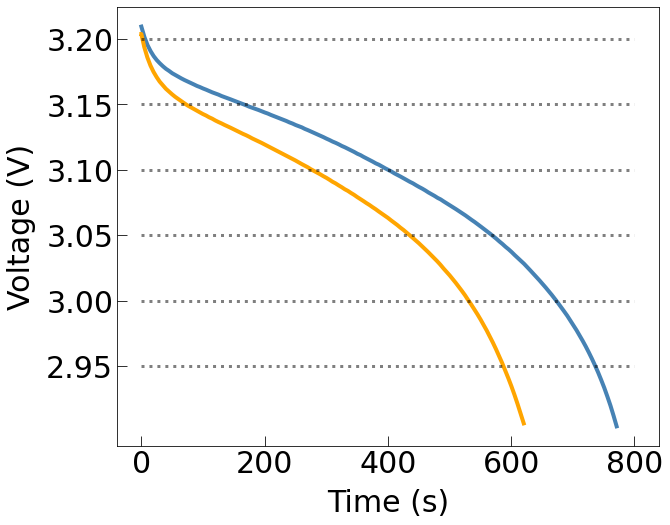

In [ ]:
voltage504 = cycle1['Voltage']
time504 = cycle1['Step_Time']
voltage505 = cycle700['Voltage'] 
time505 = cycle700['Step_Time']


ax = plt.figure(figsize=(10,8))
plt.plot(time504,voltage504,linewidth=4,color='steelblue')
plt.plot(time505,voltage505,linewidth=4,color='orange')


for v in voltage_lst:
  # vt = cycle1.loc[cycle1['Voltage']<v].iloc[0,0]-1
  # time=cycle1.loc[cycle1['idx']==vt].iloc[0,3]
  plt.plot([0,800],[v,v],color='black',linewidth=3,linestyle='dotted',alpha=0.5)

plt.ylabel('Voltage (V)',labelpad=10)
plt.xlabel('Time (s)',labelpad=10)
plt.yticks([2.95,3,3.05,3.1,3.15,3.2])
plt.xticks([0,200,400,600,800])
plt.tick_params(direction='in',length=10)
# plt.legend(frameon=False)
plt.tight_layout() # 피규어 안짤리게 해줌
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/mi score/mi score width.png',dpi=600)

In [ ]:
CV=pd.DataFrame(test.groupby('Cycle_Index')['Voltage'].sum())
# CV=CV[CV.index.isin(lst)]
CV['lag'] = CV['Voltage'].shift(1)

In [ ]:
CV['decrease'] = CV['lag']-CV['Voltage']
CV = CV.fillna(0)
CV = CV.reset_index(drop=True)
CV

,Voltage,lag,decrease
0,1554.841410,0.000000,0.000000
1,1554.820140,1554.841410,0.021270
2,1555.001842,1554.820140,-0.181703
3,1554.968403,1555.001842,0.033440
4,1555.154527,1554.968403,-0.186125
...,...,...,...
2228,1537.286089,1539.744118,2.458029
2229,1535.248191,1537.286089,2.037898
2230,1534.103096,1535.248191,1.145095
2231,1533.687940,1534.103096,0.415157


In [ ]:
CV['decrease_p'] = CV['decrease']/CV['lag'] *100
CV

,Voltage,lag,decrease,decrease_p
0,1554.841410,0.000000,0.000000,NaN
1,1554.820140,1554.841410,0.021270,0.001368
2,1555.001842,1554.820140,-0.181703,-0.011686
3,1554.968403,1555.001842,0.033440,0.002150
4,1555.154527,1554.968403,-0.186125,-0.011970
...,...,...,...,...
2228,1537.286089,1539.744118,2.458029,0.159639
2229,1535.248191,1537.286089,2.037898,0.132565
2230,1534.103096,1535.248191,1.145095,0.074587
2231,1533.687940,1534.103096,0.415157,0.027062


In [ ]:
all_CV = pd.concat([all_CV,CV['decrease_p']],axis=1)

In [ ]:
all_CV.columns = ['b1c31','b2c1','b1c2']
all_CV

,b1c31,b2c1,b1c2
0,NaN,NaN,NaN
1,-0.005301,-0.060320,0.001368
2,-0.007587,-0.035261,-0.011686
3,-0.009588,0.014080,0.002150
4,0.002728,-0.020277,-0.011970
...,...,...,...
2228,NaN,NaN,0.159639
2229,NaN,NaN,0.132565
2230,NaN,NaN,0.074587
2231,NaN,NaN,0.027062


In [ ]:
CV[CV['decrease_p']>0].sum()

Voltage       1.675279e+06
lag           1.676063e+06
decrease      7.835269e+02
decrease_p    5.043838e+01
dtype: float64

In [ ]:
CV[CV['decrease_p']<0].sum()

Voltage       1.791051e+06
lag           1.790290e+06
decrease     -7.616561e+02
decrease_p   -4.908369e+01
dtype: float64

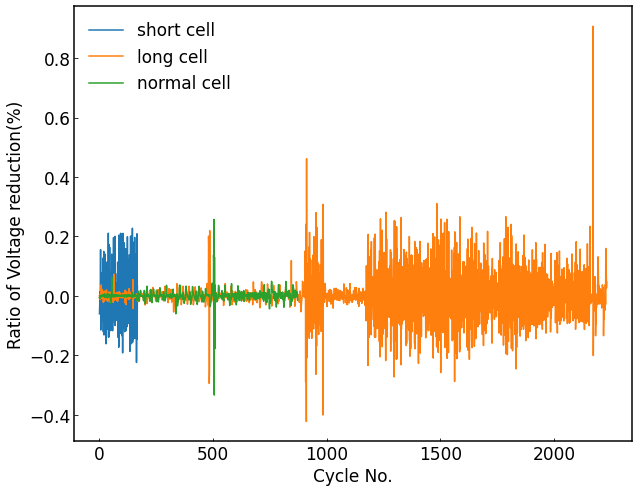

In [ ]:
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
plt.rc('font', size=17)
fig = plt.figure(figsize=(10,8))

plt.plot(all_CV.b2c1,label='short cell')
plt.plot(all_CV.b1c2,label='long cell')
plt.plot(all_CV.b1c31,label='normal cell') 

plt.xlabel('Cycle No.')
plt.ylabel('Ratio of Voltage reduction(%)')
plt.tick_params(direction='in')
plt.legend(frameon=False)
plt.savefig('/content/drive/MyDrive//battery capcity estimation/figure/비선형성_voltage_reduction_.png',dpi=600)

In [ ]:
CV[CV.index ==1].values[0][0]

1546.8803152764672

In [ ]:
# time504 = time504.reset_index()
# voltage504 = voltage504.reset_index()
time505 = time505.reset_index(drop=True)
voltage505 = voltage505.reset_index(drop=True)
time506 = time506.reset_index(drop=True)
voltage506 = voltage506.reset_index(drop=True)
time507 = time507.reset_index(drop=True)
voltage507 = voltage507.reset_index(drop=True)
time508 = time508.reset_index(drop=True)
voltage508 = voltage508.reset_index(drop=True)
time509 = time509.reset_index(drop=True)
voltage509 = voltage509.reset_index(drop=True)

In [ ]:
gr = []
gr = pd.concat([time504,voltage504,time505,voltage505,time506,voltage506,time507,voltage507,time508,voltage508,time509,voltage509],axis=1)
gr

,Step_Time,Voltage,Step_Time,Voltage,Step_Time,Voltage,Step_Time,Voltage,Step_Time,Voltage,Step_Time,Voltage
0,2.485124,3.199967,2.940147,3.200032,0.140007,3.199973,2.310116,3.200048,1.925096,3.199973,0.700035,3.200024
1,3.605180,3.197238,4.025201,3.197360,1.050053,3.197853,3.185159,3.197643,2.660133,3.197396,1.295065,3.197275
2,4.725236,3.194916,5.145257,3.195233,1.995100,3.195652,4.060203,3.195446,3.395170,3.195162,1.890095,3.194526
3,5.845292,3.192937,6.265313,3.193137,2.940147,3.193451,4.935247,3.193492,4.165208,3.192971,2.485124,3.192005
4,6.965348,3.190959,7.385369,3.191041,3.885194,3.191250,5.810291,3.191538,4.900245,3.190880,3.080154,3.189718
...,...,...,...,...,...,...,...,...,...,...,...,...
495,557.507875,3.002228,556.632832,3.002407,467.903395,3.002016,438.746937,3.001843,371.788589,3.001686,296.184809,3.001490
496,558.627931,3.001668,557.752888,3.001827,468.848442,3.001481,439.621981,3.001385,372.523626,3.001276,296.779839,3.001124
497,559.747987,3.001109,558.872944,3.001246,469.793490,3.000946,440.497025,3.000927,373.293665,3.000847,297.374869,3.000754
498,560.868043,3.000563,559.993000,3.000648,470.738537,3.000462,441.372069,3.000470,374.028701,3.000438,297.969898,3.000385


In [ ]:
gr.to_excel('/content/drive/MyDrive//battery capcity estimation/figure/figure7_b.xlsx')

plotting...


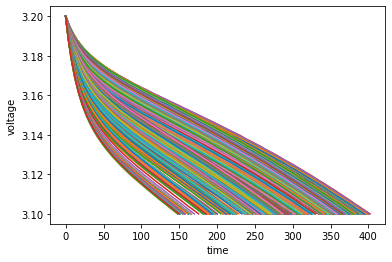

In [ ]:
test_data = fit_spline(test_csvs.copy(), test_cycles, no_points=500)
plot_cycles(test_data, test_cycles)

# MIT_d

In [17]:
# 모든 셀의 데이터를 fit spline함수 진행.
mit_d = fit_spline(mit_data.copy(), mit_cycles, no_points=500)

ValueError: ignored

# fig 7 추출

In [28]:
# reducted discharge voltage curve(data after reduction)
fig7_csvs = ['/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv',
            '/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv',
            '/content/drive/MyDrive//battery capcity estimation//Battery SOH//DATA//MIT discharge data//b3c16corrected.csv',
            '/content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv']
#  '/content/drive/MyDrive//battery capcity estimation//data//2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv' ]
# '/content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv' ]
# '/content/drive/MyDrive//battery capcity estimation//data//b1c1corrected.csv' ]
# '/content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv']
# '/content/drive/MyDrive//battery capcity estimation//Battery SOH//DATA//MIT discharge data//b3c16corrected.csv']

In [29]:
fig7_csvs, fig7_cycles = load_csvs(fig7_csvs)
fig7_data = fit_spline(fig7_csvs.copy(), fig7_cycles, no_points=500)

170
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (52984, 8)
874
total points in /content/drive/MyDrive//battery capcity estimation//data//2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (291392, 8)
1637
total points in /content/drive/MyDrive//battery capcity estimation//Battery SOH//DATA//MIT discharge data//b3c16corrected.csv (400729, 8)
2235
total points in /content/drive/MyDrive//battery capcity estimation//data//b1c2corrected.csv (753645, 8)


# 회귀분석을 통해 soh의 선형성 확인

In [30]:
from statsmodels.formula.api import ols

In [31]:
fig7_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84500 entries, 0 to 84499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Step_Time        84500 non-null  float64
 1   Voltage          84500 non-null  float64
 2   Charge_Capacity  84500 non-null  float64
 3   Cycle_Index      84500 non-null  float64
dtypes: float64(4)
memory usage: 2.6 MB


In [32]:
fig7_data[0].head()

,Step_Time,Voltage,Charge_Capacity,Cycle_Index
0,2.485124,3.199967,1.071564,1.0
1,3.850193,3.196641,1.071564,1.0
2,5.250263,3.193988,1.071564,1.0
3,6.650333,3.191515,1.071564,1.0
4,8.050403,3.189042,1.071564,1.0


In [33]:
test_model = []
for test in fig7_data:
  model = ols(formula = 'Charge_Capacity ~ Step_Time',data = test).fit()
  test_model.append(model)

In [38]:
test_model[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Charge_Capacity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     102.1
Date:                Wed, 24 May 2023   Prob (F-statistic):           5.40e-24
Time:                        01:50:15   Log-Likelihood:             1.7798e+06
No. Observations:             1116500   AIC:                        -3.560e+06
Df Residuals:                 1116498   BIC:                        -3.559e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0305   9.36e-05    1.1e+04      0.000       1.030       1.031
Step_Time   2.335e-06   2.31e-07     10.102      0.000    1.88e-06    2.79e-06
==============================================================================
Omnibus:                   148975.168   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           216367.192
Skew:                          -1.064   Prob(JB):                         0.00
Kurtosis:                       3.354   Cond. No.                         814.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
fig7_data_n = []
for data in fig7_data:
    data = data.drop_duplicates(subset='Cycle_Index')
    data = data.iloc[:,2:4]
    min = 1
    max = data.iloc[-1,1]
    data['Cycle_Index'] = (data['Cycle_Index']-min)/(max-min) # min max scaling
    max= np.max(data['Charge_Capacity'])
    min = np.min(data['Charge_Capacity'])
    data['Charge_Capacity']= (data['Charge_Capacity']-min)/(max-min)
    fig7_data_n.append(data)

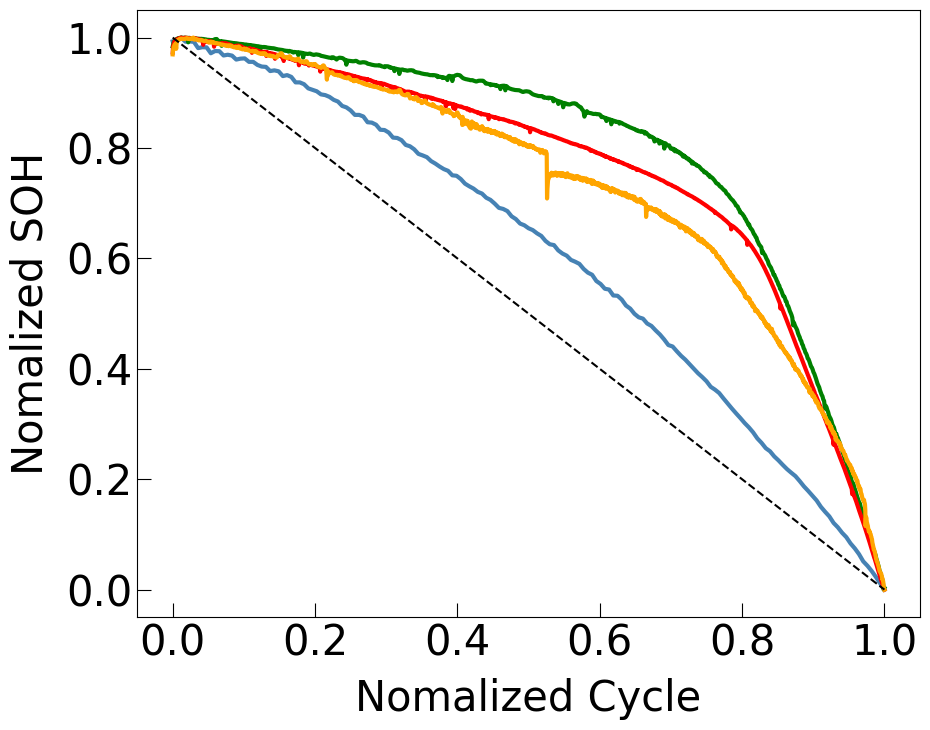

In [29]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(10,8))
# plt.rc('font', size=18)
ytl=['steelblue', 'g', 'r', 'orange']
i = 0
for data in fig7_data_n:
    normal = plt.plot(data.Cycle_Index,data.Charge_Capacity,color=ytl[i],linewidth=3)
    i = i+1

plt.plot([0,1],[1,0],color='black',linestyle='--')
plt.xlabel('Nomalized Cycle',labelpad=10)
plt.ylabel('Nomalized SOH',labelpad=10)
# plt.yticks(np.arange(0.8,1.02,0.025))
# plt.legend(handles=[black,blue,red])
plt.tick_params(direction='in',length=10)
plt.tight_layout()
# # 범례 지정하기
# v1 = mlines.Line2D([], [], color='b',label='b1c25')
# v2 = mlines.Line2D([], [], color='g',label='b1c20')
# v3 = mlines.Line2D([], [], color='r',label='b1c24')
# v4 = mlines.Line2D([], [], color='c',label='b1c15')

# #범례 나타내기
# plt.legend(handles=[v1,v2,v3,v4],frameon=False)
# plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/soh_by_scaling.png',dpi=600)

In [ ]:
fig7 = test_data[0]
for i in range(1,5):
    fig7 = pd.concat([fig7,test_data[i]],axis=1)

In [ ]:
fig7

,Charge_Capacity,Cycle_Index,Charge_Capacity,Cycle_Index,Charge_Capacity,Cycle_Index,Charge_Capacity,Cycle_Index,Charge_Capacity,Cycle_Index
0,1.094660,1.0,1.080340,1.0,1.071564,1.0,1.075059,1.0,1.079770,1.0
1,1.095918,2.0,1.081733,2.0,1.072120,2.0,1.076450,2.0,1.081137,2.0
2,1.096691,3.0,1.082531,3.0,1.073200,3.0,1.077113,3.0,1.081908,3.0
3,1.097099,4.0,1.083014,4.0,1.071404,4.0,1.077759,4.0,1.082509,4.0
4,1.097407,5.0,1.083233,5.0,1.071500,5.0,1.078350,5.0,1.082751,5.0
...,...,...,...,...,...,...,...,...,...,...
2228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.884467,2231.0
2229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883290,2232.0
2230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882497,2233.0
2231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.881563,2234.0


In [ ]:
fig7 = fig7.reset_index(drop=True)
fig7.to_csv('figure7.csv',index=False)

# 모델링

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


    
# creating a four layer neural network.
# number of elements in input layer = segment length x 2
# 2 hidden layers each with two hundred units

    
# Neural Net to predict capacity # 다층 신경망 구조
class CapacityNet(nn.Module):
    def __init__(self):
        super(CapacityNet, self).__init__()

        self.l1 = nn.Linear(in_features= int(500 * 2), out_features=400) # 입력차원 1000, 출력 400
        self.l2 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l3 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l4 = nn.Linear(in_features=400, out_features=200) # 입력차원 400, 출력 200
        self.l5 = nn.Linear(in_features=200, out_features=100) # 입력차원 200, 출력 100
        self.l6 = nn.Linear(in_features=100, out_features=1) # 입력차원 100, 출력 1
        
    def forward(self, x):
        x = F.relu(self.l1(x)) # reLu 
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        return self.l6(x)

    

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from bisect import bisect
  

# procesing data to get samples for training and testing
# minibatch gradient descnet 사용    
class CapacityDataset(Dataset):
    def __init__(self, data, type="train"):
        self.cycles = []

        for d in data:
            self.cycles.append(d.Cycle_Index.unique())
        self.data = data
#         self.window = window
        # cycles per cell
        self.spc = [cycle.shape[0] for cycle in  self.cycles]
        
    def __len__(self):
        return sum(self.spc)

    def __getitem__(self, idx):
        
        # the next three lines are locating the index in cycles of a particular cell
        
        cumsum = np.cumsum(self.spc)
        cell_no = bisect(cumsum, idx)
        ind = idx if cell_no == 0 else idx - cumsum[cell_no - 1]
        
        # picking the value of time, voltage, and capacity for the specified cycle during training or testing
        
        time_step = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Step_Time.values
        voltage = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Voltage.values
        capacity = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Charge_Capacity.max()
        
        # choosing a segment of specified length from the discharge curve for training or testing
        # if random = True, the segment will start anywhere from start of curve to 400- length of segment
#         print (time_step.shape, voltage.shape, cell_no, ind, capacity )

#         segment_length = np.random.randint(self.window[0], self.window[1])
#         start = 0 if not self.random else np.random.randint(0, 400 - segment_length)
#         time_x = time_step[start: start+segment_length]
#         voltage_x = voltage[start: start+segment_length]
        # creating input / feature vector (segment length x2)
        # the vector has voltage values followed by the corresponding time values
#         x = np.zeros((voltage_x.shape[0]*2))
        x = np.zeros((voltage.shape[0]*2))
#         max_segment = np.zeros((self.max_points * 2)) 
        x[::2] = voltage
        x[1::2] = time_step / 100
#         x_random_seg = np.zeros(((self.window[1] - 1) * 2))
#         x_random_seg[:x.shape[0]] = x

#         max_segment[:x.shape[0]] = x


        return x , torch.from_numpy(np.array([capacity]))


In [ ]:
train_voltage_c = CapacityDataset(mit_d[:4]) # 보충자료에 의한 학습 입력 데이터로 바꿔주었다. 원래는 :5 였음
train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True) # batch_size 64개 

# valid와 test는 한개의 데이터 셋으로 진행되므로 shuffle이 false여도 상관 없다.
valid_voltage_c = CapacityDataset([mit_d[4]])
valid_loader_c = DataLoader(valid_voltage_c, batch_size=64, shuffle=False) 

test_mit = CapacityDataset(test_data)
test_loader_mit = DataLoader(test_mit, batch_size=64, shuffle=False)

# Net to predict Capacity
net =  CapacityNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.000561) # optimizer로 adam을 사용하며 학습률은 0.000561이다.
criteria = torch.nn.MSELoss() # loss function : MSE
scheduler = StepLR(optimizer, step_size=4, gamma=0.99)


def train(net, best, train_set, test_set, optimizer, criteria, epoch, best_mape):
    for dset, mode in [(train_set, 'train'), (test_set, 'test')]: # looping over two dataloaders (train and test)
        if mode == "test":
            net.eval() # if testing, don't compute gradients 
        else:
            net.train()
        loss = 0
        preds = []
        target = []
        for ind, (x, y) in enumerate(dset): # looping over dataloader (train or test)
            x = x.float()  #converting datatype to float, data type of inputs must match the datatype of weights of network
            y = y.float()

            pred = net(x) # neural net forward is called with input x. it will return capacity
            loss = criteria(pred, y) # computing mean square error between predicted capacity and target capacity
#             print (mode)
            if mode == "test":
                preds.extend(pred.detach().numpy().reshape(-1)) # if test dataloader, save the predictions for further analysis
                target.extend(y.cpu().numpy())
            if mode == 'train':
                optimizer.zero_grad() # if train mode, if there are any gradients from previous time step, set them to 0
                loss.backward()  # back propagation
                optimizer.step() # updating the weights
            loss += loss.item()  # converting loss(pytorch tensor) to python object and adding the value to total loss
    
    mape =  mean_absolute_percentage_error(preds, target) # computing the error of epoch
    if mape < best_mape and mode == "test":
        best = copy.deepcopy(net) #if error is less than the best error observed so far. save the model
        best_mape = mape # current error is the least error so for. so setting it as the best mape
    print (f'Mode: {mode} __ Epoch: {epoch} __ Loss: {loss/len(dset)}, mape: {mape}, Best Mape: {best_mape}')
    return net, best, best_mape # return the trained net

In [ ]:
best_mape=4
best=None
for epoch in range(100):
    net, best, best_mape = train(net, best, train_loader_c, valid_loader_c, optimizer, criteria, epoch, best_mape)
    print (f'Learning rate {scheduler.get_last_lr()}')
    scheduler.step()
    

Mode: test __ Epoch: 0 __ Loss: 7.624785212101415e-06, mape: 0.025293339043855667, Best Mape: 0.025293339043855667
Learning rate [0.000561]
Mode: test __ Epoch: 1 __ Loss: 2.4732684323680587e-05, mape: 0.011920472607016563, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 2 __ Loss: 2.997094634338282e-05, mape: 0.012779932469129562, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 3 __ Loss: 4.51205087301787e-05, mape: 0.012410699389874935, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 4 __ Loss: 6.057123391656205e-05, mape: 0.012112116441130638, Best Mape: 0.011920472607016563
Learning rate [0.00055539]
Mode: test __ Epoch: 5 __ Loss: 5.712182246497832e-05, mape: 0.013284140266478062, Best Mape: 0.011920472607016563
Learning rate [0.00055539]
Mode: test __ Epoch: 6 __ Loss: 8.582628652220592e-05, mape: 0.011405347846448421, Best Mape: 0.011405347846448421
Learning rate [0.00055539]
Mode: test __ 

Mode: test __ Epoch: 55 __ Loss: 9.47404041653499e-05, mape: 0.008534379303455353, Best Mape: 0.007997739128768444
Learning rate [0.0004922892939024209]
Mode: test __ Epoch: 56 __ Loss: 1.2644927664950956e-05, mape: 0.015516809187829494, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 57 __ Loss: 8.753235306357965e-05, mape: 0.00820237398147583, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 58 __ Loss: 1.908610101963859e-05, mape: 0.010945347137749195, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 59 __ Loss: 5.136287200002698e-06, mape: 0.01715458743274212, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 60 __ Loss: 2.376176416873932e-05, mape: 0.00839995127171278, Best Mape: 0.007997739128768444
Learning rate [0.00048249273695376266]
Mode: test __ Epoch: 61 __ Loss: 7.150792953325436e-05, mape: 0.0069665107

pretraining은 전체 전압 방전곡선으로 모델 학습

pretraining2는 전압 방전곡선의 세그먼트로 모델학습

In [ ]:
torch.save(best.state_dict(), "./pretraining_full.pt")

In [ ]:
best_model = CapacityNet()
best_model.load_state_dict(torch.load("/content/drive/MyDrive//battery capcity estimation//code//pretraining_full.pt"))
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)


 TEST MIT
(1636,) (1636,)
MAPE: 0.05040272837758179
RMSE : 0.003437576399011296
R2 Score : -63.22157486756609


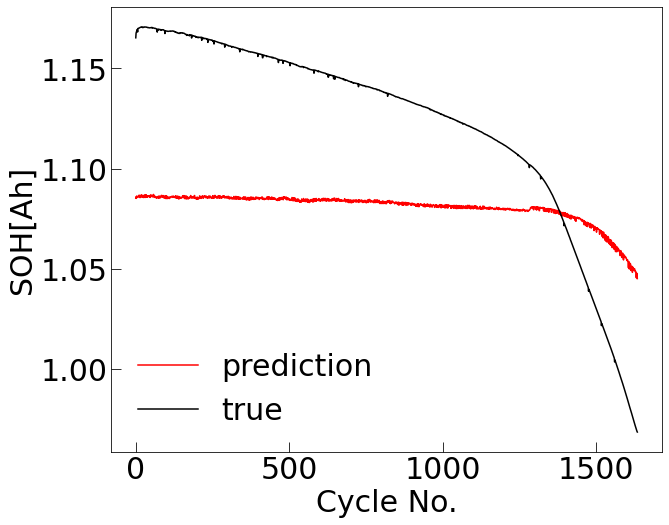

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# # Plot the capacity curve for cell 3 and predicted capacities for cell 3
# valid_nasa = CapacityDataset([nasa_data[3]], type='test', window=[25, 26], random=True)
# valid_mit = CapacityDataset([mit_data[4]], type='test', window=[25, 26],random=True)

# valid_loader_nasa = DataLoader(valid_nasa, batch_size=16,  shuffle=False)
# valid_loader_mit = DataLoader(valid_mit, batch_size=16, shuffle=False)

# test_mit = CapacityDataset([mit_data[5]], type='test', window=[25, 26], random=True)
# test_loader_mit = DataLoader(test_mit, batch_size=16, shuffle=False)


# for loader, type in ([(valid_loader_c, "Valid MIT")]): # 검증 데이터 비교
for loader, type in ([(test_loader_mit, "TEST MIT")]): # 테스트 데이터 비교
    print ("\n", type)
    preds = [best_model(x.float()) for x, _, in loader]
    y =  [x for _, x in loader]
    y = torch.cat(y).view(-1).detach().numpy()*1.1
    preds = torch.cat(preds).view(-1).detach().numpy()*1.1
    print (preds.shape, y.shape)
    plt.figure(figsize=(10, 8))
    plt.plot(np.arange(preds.shape[0]),preds,label="prediction",color='r')
    plt.plot(np.arange(preds.shape[0]),y,label="true",color='black')
    plt.xlabel('Cycle No.')
    plt.ylabel('SOH[Ah]')
    plt.tick_params(direction='in',length=10)
    plt.tight_layout() # 피규어 안짤리게 해줌
    error_train_mape = mean_absolute_percentage_error(preds, y)
    error_train_rmse = mean_squared_error(preds, y)
    error_train_r2 = r2_score(preds, y)
    
    print(f"MAPE: {error_train_mape}" )
    print(f"RMSE : { error_train_rmse}")
    print(f"R2 Score : {error_train_r2}")
    
    plt.legend(frameon=False)

# 데이터 분석

In [ ]:
y= y.tolist()
preds = preds.tolist()

In [ ]:
df = pd.DataFrame({"true":y,"prediction":preds})
df

,true,prediction
0,1.094660,1.086064
1,1.095918,1.089925
2,1.096691,1.088318
3,1.097099,1.088752
4,1.097407,1.089199
...,...,...
869,0.887021,0.896360
870,0.885937,0.895354
871,0.884920,0.894438
872,0.881562,0.895476


In [ ]:
df['cycle']=range(len(df))
df['cycle'] = df['cycle']+1

In [ ]:
df = df[['cycle','true','prediction']]
df

,cycle,true,prediction
0,1,1.094660,1.086064
1,2,1.095918,1.089925
2,3,1.096691,1.088318
3,4,1.097099,1.088752
4,5,1.097407,1.089199
...,...,...,...
869,870,0.887021,0.896360
870,871,0.885937,0.895354
871,872,0.884920,0.894438
872,873,0.881562,0.895476


In [ ]:
df.to_csv('figure5_c1.csv',index=False)

MAPE : 0.014427603604320171


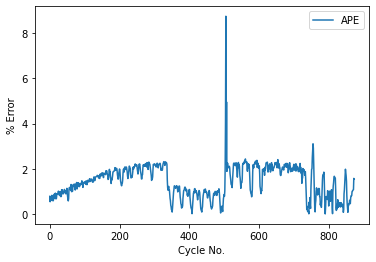

In [ ]:
df['APE']= np.abs((df['prediction']-df['true'])/df['true'])*100
plt.plot(df['APE'],label='APE')
plt.ylabel('% Error')
plt.xlabel('Cycle No.')
plt.legend()
print("MAPE : {}".format(df['APE'].mean(axis=0)/100))

In [ ]:
df1 = df[['cycle','APE']]
df1.to_csv('figure5_c2.csv',index=False)

In [ ]:
df[df['APE']>3]
# outlier_cycle = [506,507,508]
# outlier_cycle = np.array(outlier_cycle,dtype='int64')

,y,preds,APE
505,1.067116,1.012281,5.138584
507,1.068396,1.035496,3.079358


In [ ]:
test = test_data[0]
test

,Step_Time,Voltage,Charge_Capacity,Cycle_Index
0,6.160308,3.199996,0.995145,1.0
1,7.490375,3.198369,0.995145,1.0
2,8.820441,3.196742,0.995145,1.0
3,10.150508,3.195159,0.995145,1.0
4,11.480574,3.193929,0.995145,1.0
...,...,...,...,...
436995,392.229611,3.002192,0.801993,874.0
436996,393.034652,3.001634,0.801993,874.0
436997,393.804690,3.001100,0.801993,874.0
436998,394.609730,3.000542,0.801993,874.0


In [ ]:
cycles = test_cycles[0]
cycles = cycles.tolist()

In [ ]:
capacity = test.loc[test['Cycle_Index']==1]['Charge_Capacity'][0]
init = test.loc[test['Cycle_Index']==1]['Step_Time'].iloc[0]
last = test.loc[test['Cycle_Index']==1]['Step_Time'].iloc[-1]
print(last-init)
cap = []
cap.append(capacity)
cap
last-init

667.0983549177458


667.0983549177458

Capacity vs discharge time 

In [ ]:
capacity = []
discharge_time = []
for i in cycles:
    cap = test.loc[test['Cycle_Index']==i]['Charge_Capacity'].iloc[0]
    init = test.loc[test['Cycle_Index']==i]['Step_Time'].iloc[0]
    last = test.loc[test['Cycle_Index']==i]['Step_Time'].iloc[-1]
    time = last-init
    capacity.append(cap)
    discharge_time.append(time)

In [ ]:
df1 = pd.DataFrame({'capacity':capacity,'discharge_time':discharge_time},index=cycles)

In [ ]:
df1['capacity'] = df1['capacity']*1.1

In [ ]:
df1.to_csv('figure3_b.csv',index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

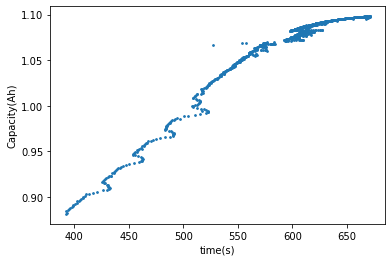

In [ ]:
plt.scatter(x=df1.discharge_time,y=df1.capacity,s=3)
plt.ylabel('Capacity(Ah)')
plt.xlabel('time(s)')
plt.show

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

이상값 확인

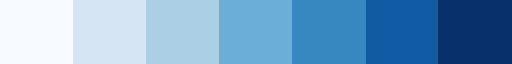

In [ ]:
from matplotlib import cm
blues = cm.get_cmap("Blues", lut=7)
blues

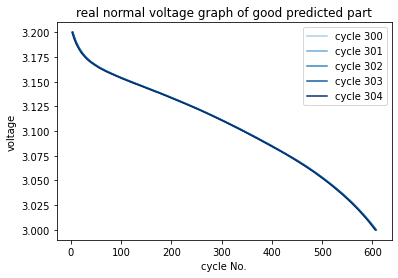

In [ ]:
test = test_data[0]
voltage504 = test.loc[test['Cycle_Index']==300]['Voltage']
time504 = test.loc[test['Cycle_Index']==300]['Step_Time']
voltage505 = test.loc[test['Cycle_Index']==301]['Voltage'] # 에러가 높아진 부분
time505 = test.loc[test['Cycle_Index']==301]['Step_Time']
voltage506 = test.loc[test['Cycle_Index']==302]['Voltage']
time506 = test.loc[test['Cycle_Index']==302]['Step_Time']
voltage507 = test.loc[test['Cycle_Index']==303]['Voltage'] # 에러가 높아진 부분
time507 = test.loc[test['Cycle_Index']==303]['Step_Time']
voltage508 = test.loc[test['Cycle_Index']==304]['Voltage']
time508 = test.loc[test['Cycle_Index']==304]['Step_Time']
plt.title("real normal voltage graph of good predicted part")
plt.plot(time504,voltage504,label='cycle 300',color= blues(2))
plt.plot(time505,voltage505,label='cycle 301',color= blues(3))
plt.plot(time506,voltage506,label='cycle 302',color= blues(4))
plt.plot(time507,voltage507,label='cycle 303',color= blues(5))
plt.plot(time508,voltage508,label='cycle 304',color= blues(6))
plt.ylabel('voltage')
plt.xlabel('cycle No.')
plt.legend()

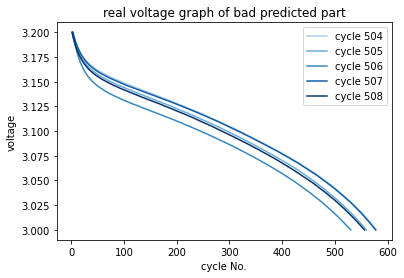

In [ ]:
test = test_data[0]
voltage504 = test.loc[test['Cycle_Index']==504]['Voltage']
time504 = test.loc[test['Cycle_Index']==504]['Step_Time']
voltage505 = test.loc[test['Cycle_Index']==505]['Voltage'] # 에러가 높아진 부분
time505 = test.loc[test['Cycle_Index']==505]['Step_Time']
voltage506 = test.loc[test['Cycle_Index']==506]['Voltage']
time506 = test.loc[test['Cycle_Index']==506]['Step_Time']
voltage507 = test.loc[test['Cycle_Index']==507]['Voltage'] # 에러가 높아진 부분
time507 = test.loc[test['Cycle_Index']==507]['Step_Time']
voltage508 = test.loc[test['Cycle_Index']==508]['Voltage']
time508 = test.loc[test['Cycle_Index']==508]['Step_Time']
plt.title("real voltage graph of bad predicted part")
plt.plot(time504,voltage504,label='cycle 504',color= blues(2))
plt.plot(time505,voltage505,label='cycle 505',color= blues(3))
plt.plot(time506,voltage506,label='cycle 506',color= blues(4))
plt.plot(time507,voltage507,label='cycle 507',color= blues(5))
plt.plot(time508,voltage508,label='cycle 508',color= blues(6))
plt.ylabel('voltage')
plt.xlabel('cycle No.')
plt.legend()

In [ ]:
test.loc[test['Cycle_Index']==504]['Charge_Capacity'].unique()

array([0.97242591])

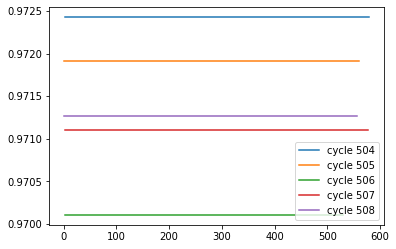

In [ ]:
test = test_data[0]

cap504 = test.loc[test['Cycle_Index']==504]['Charge_Capacity']
time504 = test.loc[test['Cycle_Index']==504]['Step_Time']
cap505 = test.loc[test['Cycle_Index']==505]['Charge_Capacity'] # 에러가 높아진 부분
time505 = test.loc[test['Cycle_Index']==505]['Step_Time']
cap506 = test.loc[test['Cycle_Index']==506]['Charge_Capacity']
time506 = test.loc[test['Cycle_Index']==506]['Step_Time']
cap507 = test.loc[test['Cycle_Index']==507]['Charge_Capacity'] # 에러가 높아진 부분
time507 = test.loc[test['Cycle_Index']==507]['Step_Time']
cap508 = test.loc[test['Cycle_Index']==508]['Charge_Capacity']
time508 = test.loc[test['Cycle_Index']==508]['Step_Time']
plt.plot(time504,cap504,label='cycle 504')
plt.plot(time505,cap505,label='cycle 505')
plt.plot(time506,cap506,label='cycle 506')
plt.plot(time507,cap507,label='cycle 507')
plt.plot(time508,cap508,label='cycle 508')
plt.legend()

<ipython-input-364-d85cde5cb311>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(504,509),y[504:509],'bo-',color='r',label="high error part")


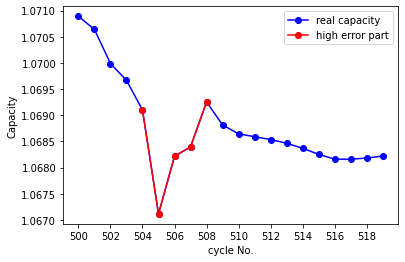

In [ ]:
plt.plot(range(500,520),y[500:520],'bo-',label='real capacity')
plt.plot(range(504,509),y[504:509],'bo-',color='r',label="high error part")
# plt.text(505, 1.673 ,'505')
plt.xticks(np.arange(500,520,2))
plt.xlabel('cycle No.')
plt.ylabel('Capacity')
plt.legend()
# plt.scatter(y[505,507])
# plt.plot(preds[505:508])

In [ ]:
test[test['Cycle_Index']==1].loc[0,'Charge_Capacity']

0.9951453636363635

In [ ]:
# b1c31, b1c42, b2c1, b1c1, b1c2
a= np.mean(preds-y)
편차평균.append(a)
편차평균

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
test_cell_list = ['b1c31','b1c42','b2c1','b1c1','b1c2']
test_cell = pd.DataFrame({'cell_name':test_cell_list,'MeanError':편차평균,'character':['normal','normal','short','long','long']})
test_cell

NameError: name '편차평균' is not defined

In [ ]:
# mean error 기준으로
# -0.01 < mean_error < 0.01 : normal cell cycle
# mean_error < -0.01 : short cell cycle
# mean_error > 0.01 : long cell cycle

In [ ]:
# cycle 수 기준으로 이상치 셀 분리한다. >> 이는 셀을 구성하는 물질에 따라 기준이 바뀔수 있어 유용하지 않은 것 같다.

In [ ]:
# test['Charge_Capacity']*=1.1

In [ ]:
vol = pd.DataFrame(test.groupby(test['Charge_Capacity'])['Voltage'].var())
cap = pd.DataFrame(test.groupby(test['Cycle_Index'])['Charge_Capacity'].mean())

In [ ]:
vol = vol.reset_index()
vol=vol.rename(columns={'Charge_Capacity':'Capacity','Voltage':'Voltage varience'})
vol

,Capacity,Voltage varience
0,0.881562,0.001955
1,0.882192,0.001965
2,0.884920,0.001951
3,0.885937,0.001957
4,0.887021,0.001968
...,...,...
869,1.098079,0.002479
870,1.098080,0.002481
871,1.098086,0.002477
872,1.098089,0.002479


Text(0, 0.5, 'Capacity(Ah)')

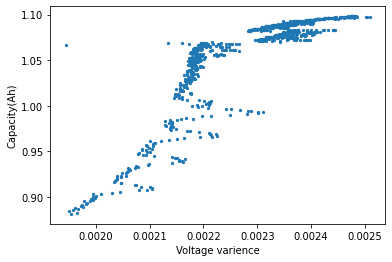

In [ ]:
plt.scatter(x='Voltage varience',y='Capacity',data=vol,s=5)
plt.xlabel('Voltage varience')
plt.ylabel('Capacity(Ah)')